## Time Serise Forecasting with ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Step1: Read the data

In [2]:
df = pd.read_csv("Assignment_Dataset_Brandintelle_Final_Data.csv", parse_dates=['DATE'], index_col=['DATE'])

In [3]:
df.head(10)

,Sr No,Sales,TV_Spends,OOH_Spends,Print_Spends,FB_Spends,FB_Impressions,Search_Spends,Paid_Search_Clicks,competitor_sales_B,events
DATE,,,,,,,,,,,
2015-11-23,1,2754371,167687,0,95463,228213,72903852,0,0,8125009,na
2015-11-30,2,2584276,214600,0,0,34258,16581099,31000,29511,7901549,na
2015-12-07,3,2547386,0,248022,3404,127691,49954773,28400,36132,8300197,event0
2015-12-14,4,2875220,625877,0,132600,84014,31649297,31900,36804,8122883,na
2015-12-21,5,2215953,0,520005,0,20687,8802269,27100,28401,7105985,na
2015-12-28,6,2569921,249189,0,239417,160110,49902081,28300,38061,7097237,na
2016-01-04,7,2171506,5152,425163,0,108690,41147695,27800,36289,6974368,na
2016-01-11,8,2464131,22141,0,176859,123894,56554690,32000,34765,7452174,na
2016-01-18,9,2012520,0,0,0,108690,35730563,22900,28023,6703566,na


### Step2: Resample

- Aggregation of data
- Daily>Monthly
- Monthly>Annual

In [4]:
ts = df[['Sales']].resample('MS').sum() # Weekly Sales to mounthly sales
ts

,Sales
DATE,
2015-11-01,5338647
2015-12-01,10208480
2016-01-01,8387068
2016-02-01,8552300
2016-03-01,6654776
2016-04-01,4317661
2016-05-01,5579664
2016-06-01,3326019
2016-07-01,4803133


In [5]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2015-11-01 to 2019-11-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   49 non-null     int64
dtypes: int64(1)
memory usage: 784.0 bytes


<AxesSubplot:xlabel='DATE'>

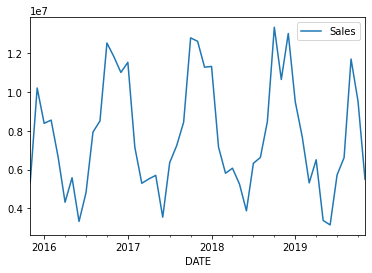

In [6]:
ts.plot()

### Step3: Stationarity Check

In [7]:
import statsmodels.api as sm

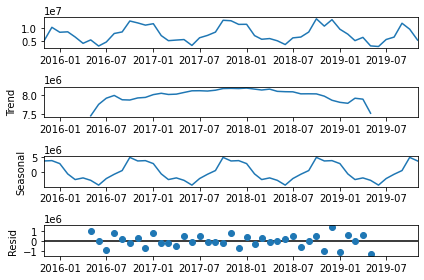

In [8]:
decomposition = sm.tsa.seasonal_decompose(ts, model = 'additive')
fig = decomposition.plot()
plt.show()

In [9]:
# Adfuller test
from statsmodels.tsa.stattools import adfuller

In [10]:
adftest = adfuller(ts['Sales'])

In [11]:
#print('pvalue of adfuller test is: ', adftest[1])
#H0 = It is non stationary
#H1 = It is stationary

def adfuller_test(Sales):
    result = adfuller(Sales)
    labels = ['ADF Test Statistic', 'p-value','#Lags Used', 'Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non satationary")

In [12]:
adfuller_test(ts['Sales'])

ADF Test Statistic : -3.4065369033034183
p-value : 0.010738037324607437
#Lags Used : 8
Number of Observations Used : 40
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### So over data is stationary pvalue of adfuller test is lower than 0.05

### Step4: Train test split

In [13]:
len(ts)

49

In [14]:
train = ts[:32]  # 2015-11-01 to 2018-06-01 
test = ts[32:]   # 2018-07-01 to 2019-11-01

### ARIMA Model Building:

ARIMA model has 3 components:
1. AR: Autoregression
2. MA: Moving Average
3. Integarted: Differencing

- Regression with its past values
    - Yt = a + b1Yt-1 + b3Yt-2 + b3Yt-3 + Error1
    - SalesDec = a + b1SalesNov + b3SalesOct + b3SalesSep + Error1
   
- P = ORDER OF AR; p = 3 that means yt is dependent on past 3 periods.
- P from PACF Plot.
- PACF is a plot that shows the correlation of a series with its lagged values.




In [15]:
# Seasonal first difference
#ts['Seasonal_First_Difference'] = ts['Sales'] - ts['Sales'].shift(12)
#ts

### Auto Regressive Model|

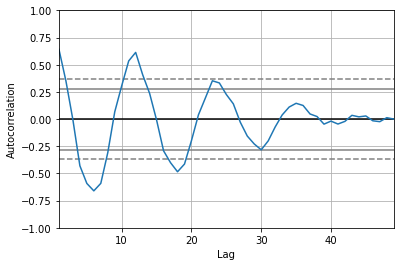

In [16]:
from pandas.plotting import autocorrelation_plot #Package pandas.tools.plotting was moved to pandas.plotting
autocorrelation_plot(ts['Sales'])
plt.show()

In [17]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


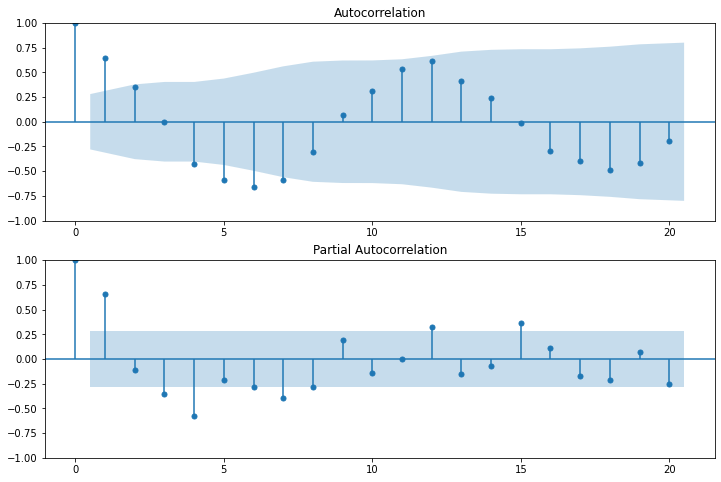

In [18]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['Sales'],lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['Sales'],lags = 20, ax = ax2)

In [19]:
# For non seasonal data
#p = 1, d = 1, q = 0 or 1
from statsmodels.tsa.arima.model import ARIMA # ARIMA should be salected when your data is non - seasonal

In [20]:
model = ARIMA(ts, order = (1,1,1))
model_fit = model.fit()

In [21]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   49
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -771.997
Date:                Sun, 23 Apr 2023   AIC                           1549.993
Time:                        09:32:28   BIC                           1555.607
Sample:                    11-01-2015   HQIC                          1552.115
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7345      0.165      4.458      0.000       0.412       1.057
ma.L1         -0.9920      0.254     -3.908      0.000      -1.489      -0.495
sigma2      5.724e+12   4.37e-14   1.31e+26      0.000    5.72e+12    5.72e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.66   Prob(JB):                         0.38
Heteroskedasticity (H):               1.18   Skew:                             0.47
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+41. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='DATE'>

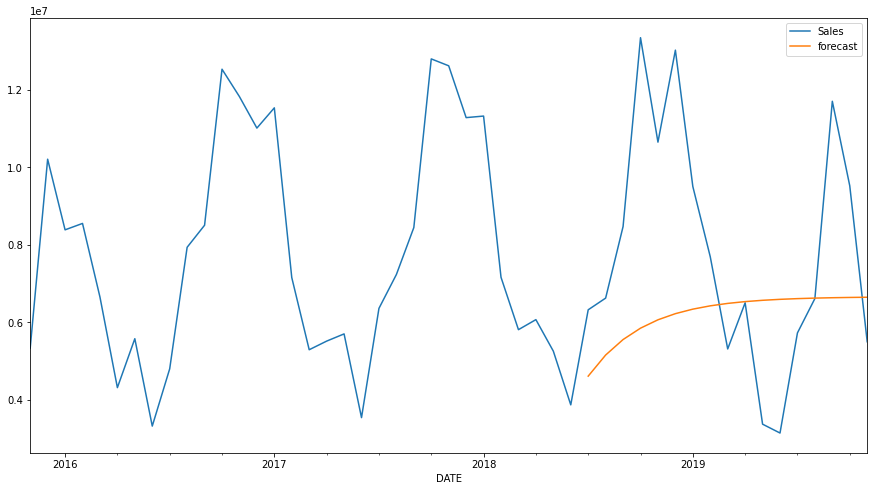

In [35]:
ts['forecast'] = model_fit.predict(start=32,end=48,dynamic=True)
ts[['Sales','forecast']].plot(figsize=(15,8))

In [52]:
model = sm.tsa.statespace.SARIMAX(ts['Sales'],order=(1,1,1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<AxesSubplot:xlabel='DATE'>

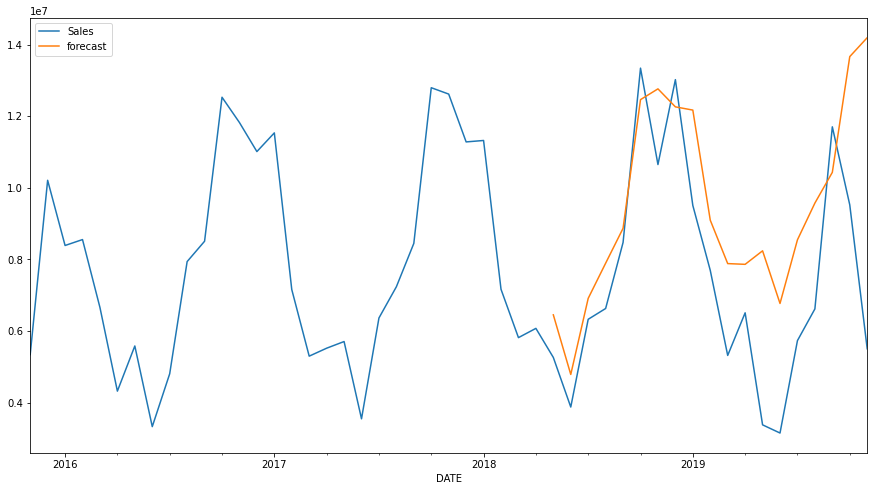

In [53]:
ts['forecast'] = results.predict(start=30,end=48,dynamic=True)
ts[['Sales','forecast']].plot(figsize=(15,8))

In [55]:
from pandas.tseries.offsets import DateOffset
future_dates = [ts.index[-1] + DateOffset(months = x) for x in range(0,24)]

In [57]:
future_datest_ts = pd.DataFrame(index = future_dates[1:], columns = ts.columns)

In [58]:
future_datest_ts.tail()

,Sales,forecast
2021-06-01,NaN,NaN
2021-07-01,NaN,NaN
2021-08-01,NaN,NaN
2021-09-01,NaN,NaN
2021-10-01,NaN,NaN


In [60]:
future_ts = pd.concat([ts,future_datest_ts])

<AxesSubplot:>

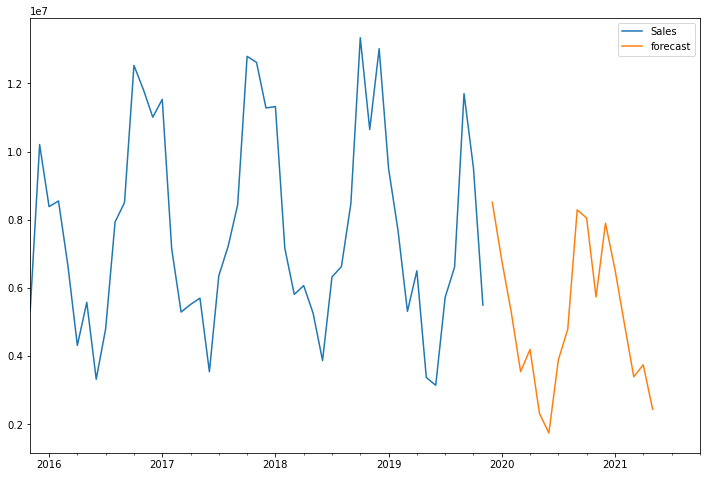

In [73]:
future_ts['forecast'] = results.predict(start = 49, end = 66, dynamic = True)
future_ts[['Sales', 'forecast']].plot(figsize = (12,8))

In [71]:
future_ts

,Sales,forecast
2015-11-01,5338647,NaN
2015-12-01,10208480,NaN
2016-01-01,8387068,NaN
2016-02-01,8552300,NaN
2016-03-01,6654776,NaN
...,...,...
2021-06-01,NaN,NaN
2021-07-01,NaN,NaN
2021-08-01,NaN,NaN
2021-09-01,NaN,NaN


In [ ]:
(len(ts)-20),len(ts)

In [ ]:
predict = model_fit.predict(start=(len(ts)-21),end=len(ts))

In [ ]:
predict.head()

In [ ]:
predict

### Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
error = np.sqrt(mean_squared_error(ts,predict))
error

In [ ]:
ts.mean(), np.sqrt(ts.var())

In [ ]:
ts.plot(legend = True, label = 'ts', figsize = (10,6))
predict.plot(legend = True, label = 'predictionARIMA')